## CNN Model with Transfer Learning
The advanced Convolution Neural Network is a combination of two models. 

* The 1st model is a species classifier named "animal classifier model", which was trained on 10,000 animal faces datasets consisting a set of species such that the model learned to identify e.g. cat from dog, and dog from others. The labels of the animal dataset were respectively: cat, dog, and wild.
  * This model consists of five 2D Convolutional layers activated with ReLU functions, with each layer followed by a maximum pooling layer to avoid overfitting. 
  * Once the facial segmentation is finished, this feature map outputs are fed into a flatten layer that is then connected to two fully connected layers for multi-class classification. Again, softmax function is employed as the activation function.
* The 2nd model is an emotional classifier where the emotion classification boundary would depend on the type of species, namely, the output of species classifier. It is evident that in this case, transfer learning where a pre-trained model should be embedded into this emotional model for optimal performance.
  * This model serves as the last output layers of the species classifier such that the output layers of species classifier is replaced with the 2nd model flattening layers and dense layers. These layers are for multi-emotion classes categorizing. These Layers are activated with ReLU function to learn the facial expression and softmax function to compute the probability of each class among multiple emotion classes.

## CNN Model with Transfer Learning test achievement
|           | Precision | Recall | F1-Score | Support |
|-----------|-----------|--------|----------|---------|
| Happy     | 0.60      | 0.50   | 0.55     | 52      |
| Sad       | 0.59      | 0.67   | 0.63     | 55      |
| Angry     | 0.68      | 0.70   | 0.69     | 43      |
|           |           |        |          |         |
| Accuracy  |           |        | 0.62     | 150     |
| Macro avg | 0.62      | 0.62   | 0.62     | 150     |
| Weighted avg | 0.62   | 0.62   | 0.62     | 150     |

### Transfer Learning Briefing
Using data from a different task. 

**Concept of Transfer Learning:** 
* Transfer learning is a technique where you use data and learned features from one task to improve performance on a different but related task.
* Especially useful when you have limited data for your target task. 

**Process of Transfer Learning:**
* Start by training a large neural network on a big dataset (e.g., 1 million images of various classes).
* Transfer the learned features (weights and biases) of the initial layers to a new neural network, but replace the output layer to suit your specific task (e.g., recognizing digits 0-9).

**Two options for further training:** 
* Train only the new output layer's parameters (useful for very small datasets). 
* Train all parameters in the network, using the transferred weights as initial values (better for slightly larger datasets). 

**Benefits of Transfer Learning:**
* Allows for training on smaller datasets by utilizing pre-learned features.
* Effective in leveraging large pre-trained models available online, saving time and computational resources.
* Particularly beneficial when pre-training and fine-tuning tasks have similar types of input data (like images or audio).

**Intuition Behind Effectiveness:**
* Early layers of neural networks often learn to detect general features (like edges, corners, or basic shapes in images) that are useful across a wide range of tasks.
* These generalized features can be effectively transferred to a new task. 

In [21]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from IPython.display import display, Image
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator


In [22]:
# Define the path to the dataset folders
happy_folder = "pets_facial_expression_dataset/happy"
sad_folder = "pets_facial_expression_dataset/Sad"
angry_folder = "pets_facial_expression_dataset/Angry"

# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128, 128))  # Resize to a fixed size for the model
            images.append(img)
    return images

# Load images and labels for each emotion
happy_images = load_images_from_folder(happy_folder)
sad_images = load_images_from_folder(sad_folder)
angry_images = load_images_from_folder(angry_folder)

# Create labels for each emotion category
happy_labels = [0] * len(happy_images)
sad_labels = [1] * len(sad_images)
angry_labels = [2] * len(angry_images)

# Concatenate images and labels
X = np.array(happy_images + sad_images + angry_images )
y = np.array(happy_labels + sad_labels + angry_labels )

# Normalize pixel values to range [0, 1]
X = X.astype('float32') / 255.0

# One-hot encode the labels
y = to_categorical(y, 3)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Load the dataset  (Optional if integrate another model)

In [ ]:
# train_gen=ImageDataGenerator(rescale=1./255)
# train_data=train_gen.flow_from_directory('pets_facial_expression_dataset/master/train',target_size=(128,128),batch_size=32,class_mode='categorical',shuffle=True) 
# val_gen=ImageDataGenerator(rescale=1./255)
# val_data=val_gen.flow_from_directory('pets_facial_expression_dataset/master/valid',target_size=(128,128),batch_size=1,class_mode='categorical',shuffle=False)
# test_gen=ImageDataGenerator(rescale=1./255)
# test_data=test_gen.flow_from_directory('pets_facial_expression_dataset/master/test',target_size=(128,128),batch_size=1,class_mode='categorical',shuffle=False)

#### Load the pre-trained model (Optional if integrate another model)

In [ ]:
# Load the pre-trained model
pretrained_animal_classifier = load_model("animal_classifier_model.h5")

# Freeze the layers of the pre-trained model
for layer in pretrained_animal_classifier.layers:
    layer.trainable = False

# Take the output from the second-to-last layer of the classifier_model
# This assumes that your classifier_model's last four layers are demse, dropout, dense, flatten
x = pretrained_animal_classifier.layers[-4].output  

# Flatten and add dense layers
x = Dense(128, activation='relu', name="face")(x)
x = Dropout(0.5)(x) # Add dropout for regularization -> 62.5% accuracy
x = Dense(3, activation='relu', name="species")(x) # Softmax for probability distribution
x = Dense(3, activation='softmax', name="emotion")(x)  # Assuming 4 classes for emotion recognition

# Create the model
emotion_model = Model(inputs=pretrained_animal_classifier.input, outputs=x)

# Print the model summary
print(emotion_model.summary())

In [ ]:
# compile the model
emotion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Calculate class weights
total_samples = len(y_train)
class_weights = {0: total_samples / np.sum(y_train[:, 0]), 
                 1: total_samples / np.sum(y_train[:, 1]), 
                 2: total_samples / np.sum(y_train[:, 2])}

# fit the model while ensuring avoiid overfitting by using early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1, mode='auto', restore_best_weights=True)
# history = emotion_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, class_weight=class_weights, callbacks=[early_stopping])
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=0, mode='auto', restore_best_weights=True)
history = emotion_model.fit(X_train, y_train, epochs=100, batch_size=32, class_weight=class_weights, callbacks=[early_stopping])

# Evaluate the model on the training set
losstr, accuracytr = emotion_model.evaluate(X_train, y_train, verbose=0)
print("Train loss:", losstr)
print("Train accuracy:", accuracytr)


# Evaluate the model on the test set
loss, accuracy = emotion_model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", loss)
print("Test accuracy:", accuracy)




In [ ]:
# Save the model
emotion_model.save("pet_facial_emotion_model.h5")

In [ ]:
# Calculate class weights
total_samples = len(y_train)
class_weights = {0: total_samples / np.sum(y_train[:, 0]), 
                 1: total_samples / np.sum(y_train[:, 1]), 
                 2: total_samples / np.sum(y_train[:, 2])}

# Train the model with class weights
history = emotion_model.fit(X_train.reshape(-1, 128, 128, 1), y_train, batch_size=32, epochs=100, validation_split=0.1, class_weight=class_weights,verbose=0)

# Evaluate the model on test data
loss, accuracy = emotion_model.evaluate(X_test.reshape(-1, 128, 128, 1), y_test)
losstr, accuracytr = emotion_model.evaluate(X_train.reshape(-1, 128, 128, 1), y_train)

print(f"Test accuracy: {accuracy*100:.2f}%")
print(f"Train accuracy: {accuracytr*100:.2f}%")

# Save the trained model
emotion_model.save("pet_facial_emotion_model.h5")

### Test on Unseen Dataset

1/1 [==============================] - 0s 163ms/step
Predicted Emotion: angry
Confidence [happy, sad, angry]: [1.2600179e-05 1.1529537e-02 9.8845786e-01]


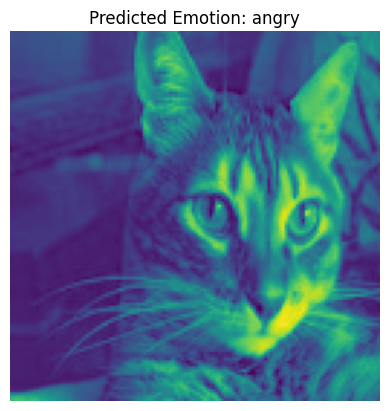

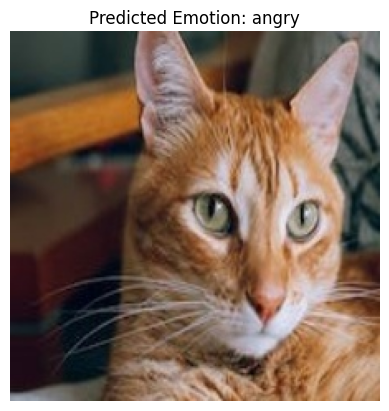

In [25]:
# Load the saved model
loaded_model = load_model("pet_facial_emotion_model.h5")
# Load a custom test image
custom_test_image_path = "pets_facial_expression_dataset/master/test/Angry/39.jpg"

custom_test_image = cv2.imread(custom_test_image_path)
# custom_test_image = cv2.cvtColor(custom_test_image, cv2.COLOR_BGR2GRAY)
custom_test_image = cv2.resize(custom_test_image, (128, 128))
custom_test_image = custom_test_image.astype('float32') / 255.0

# Reshape the image to match the model input shape
custom_test_image = np.expand_dims(custom_test_image, axis=0)
custom_test_image = np.expand_dims(custom_test_image, axis=-1)

# Make predictions on the custom test image
prediction = loaded_model.predict(custom_test_image)
prediction_prob = prediction[0]

emotion_label = np.argmax(prediction[0])

# Map the predicted label to emotion class
emotion_classes = {0: 'happy', 1: 'sad', 2: 'angry'}
predicted_emotion = emotion_classes[emotion_label]

# Print the custom test image and its predicted label
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence [happy, sad, angry]: {prediction_prob}")

import matplotlib.pyplot as plt

#Display the custom test image using matplotlib
plt.imshow(custom_test_image[0, :, :, 0])
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

from PIL import Image
# Display the original custom test image using PIL
img_pil = Image.open(custom_test_image_path)
plt.imshow(np.array(img_pil))
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

In [26]:
from sklearn.metrics import classification_report

# Get the model's predictions for the test set
y_pred = loaded_model.predict(X_test)

# Convert the predictions from categorical back to original
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['Happy', 'Sad', 'Angry'])
print(report)

5/5 [==============================] - 1s 103ms/step
              precision    recall  f1-score   support

       Happy       0.60      0.50      0.55        52
         Sad       0.59      0.67      0.63        55
       Angry       0.68      0.70      0.69        43

    accuracy                           0.62       150
   macro avg       0.62      0.62      0.62       150
weighted avg       0.62      0.62      0.62       150



1/1 [==============================] - 0s 141ms/step
Predicted Emotion: happy
Confidence [happy, sad, angry]: [0.7751606  0.21955487 0.00528455]


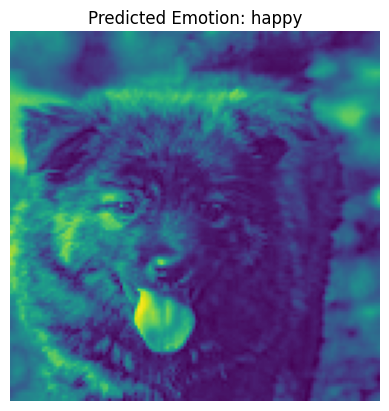

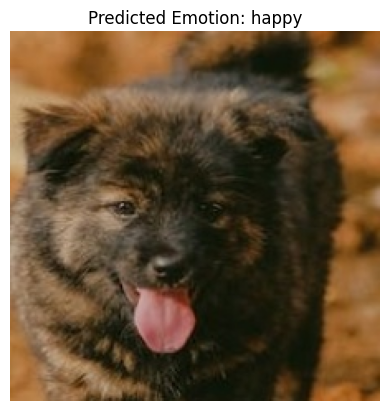

In [18]:
from keras.models import load_model
# Load the saved model
loaded_model = load_model("pet_facial_emotion_model.h5")

# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128, 128))  # Resize to a fixed size for the model
            images.append(img)
    return images


# Load a custom test image
custom_test_image_path = "pets_facial_expression_dataset/master/test/happy/016.jpg"

custom_test_image = cv2.imread(custom_test_image_path)
# custom_test_image = cv2.cvtColor(custom_test_image, cv2.COLOR_BGR2GRAY)
custom_test_image = cv2.resize(custom_test_image, (128, 128))
custom_test_image = custom_test_image.astype('float32') / 255.0

# Reshape the image to match the model input shape
custom_test_image = np.expand_dims(custom_test_image, axis=0)
custom_test_image = np.expand_dims(custom_test_image, axis=-1)

# Make predictions on the custom test image
prediction = loaded_model.predict(custom_test_image)
prediction_prob = prediction[0]

emotion_label = np.argmax(prediction[0])

# Map the predicted label to emotion class
emotion_classes = {0: 'happy', 1: 'sad', 2: 'angry'}
predicted_emotion = emotion_classes[emotion_label]

# Print the custom test image and its predicted label
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence [happy, sad, angry]: {prediction_prob}")

import matplotlib.pyplot as plt

#Display the custom test image using matplotlib
plt.imshow(custom_test_image[0, :, :, 0])
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

from PIL import Image
# Display the original custom test image using PIL
img_pil = Image.open(custom_test_image_path)
plt.imshow(np.array(img_pil))
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

1/1 [==============================] - 0s 163ms/step
Predicted Emotion: sad
Confidence [happy, sad, angry]: [0.00814684 0.98827004 0.00358305]


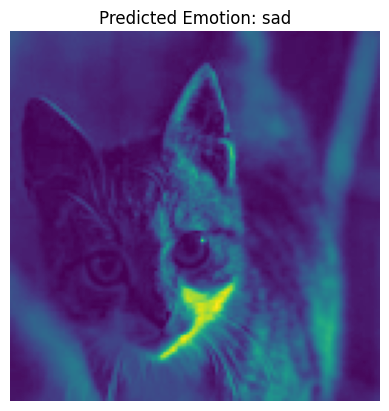

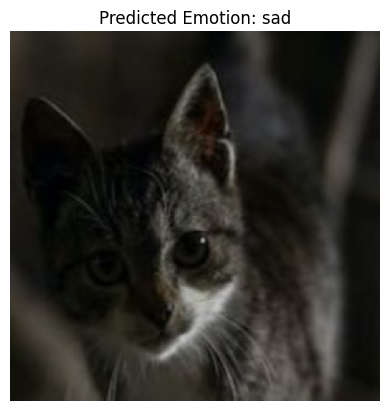

In [19]:
from keras.models import load_model
# Load the saved model
loaded_model = load_model("pet_facial_emotion_model.h5")

# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128, 128))  # Resize to a fixed size for the model
            images.append(img)
    return images


# Load a custom test image
custom_test_image_path = "pets_facial_expression_dataset/master/test/Sad/014.jpg"

custom_test_image = cv2.imread(custom_test_image_path)
# custom_test_image = cv2.cvtColor(custom_test_image, cv2.COLOR_BGR2GRAY)
custom_test_image = cv2.resize(custom_test_image, (128, 128))
custom_test_image = custom_test_image.astype('float32') / 255.0

# Reshape the image to match the model input shape
custom_test_image = np.expand_dims(custom_test_image, axis=0)
custom_test_image = np.expand_dims(custom_test_image, axis=-1)

# Make predictions on the custom test image
prediction = loaded_model.predict(custom_test_image)
prediction_prob = prediction[0]

emotion_label = np.argmax(prediction[0])

# Map the predicted label to emotion class
emotion_classes = {0: 'happy', 1: 'sad', 2: 'angry'}
predicted_emotion = emotion_classes[emotion_label]

# Print the custom test image and its predicted label
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence [happy, sad, angry]: {prediction_prob}")

import matplotlib.pyplot as plt

#Display the custom test image using matplotlib
plt.imshow(custom_test_image[0, :, :, 0])
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

from PIL import Image
# Display the original custom test image using PIL
img_pil = Image.open(custom_test_image_path)
plt.imshow(np.array(img_pil))
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()